In [175]:
import numpy as np
import pandas as pd
import sklearn.linear_model as lm
from sklearn import svm, pipeline, ensemble, datasets, feature_selection, metrics
from sklearn import model_selection
from sklearn import preprocessing as pp
import matplotlib.pyplot as plt
import sqlalchemy
import configparser

# show graphs right in the notebook (rather than in another window)
%matplotlib inline

### Загружаем данные из БД

In [ ]:
parser = configparser.ConfigParser()
parser.read('db.config')

config = parser['DEFAULT']

engine = sqlalchemy.create_engine(
        'mssql+pyodbc://' + config['username'] + 
        ':' + config['password'] + '@' + config['server'] 
        + '/' + config['database'] + "?" + config['driver'])

In [200]:
# df = pd.io.sql.read_sql("select * from PlayersStats", engine)
score_funs = ['explained_variance', 'neg_mean_squared_error', 'r2']
scorer = score_funs[int(input())]
boston = datasets.load_boston()
n_features = 5
features = boston.feature_names
target_name = 'MEDV'
df = pd.DataFrame(data=boston.data, columns=features)
df[target_name] = boston.target

X = df.iloc[:, :-1]
y = df.iloc[:, -1]
feature_filter = feature_selection.SelectKBest(feature_selection.mutual_info_regression, k=n_features).fit(X, y)
selected_features = [features[i] for i in feature_filter.get_support(indices=True)]
print('Selected {} best features: {}'.format(n_features, selected_features))
X = feature_filter.transform(X)
print(boston.DESCR)

0
Selected 5 best features: ['INDUS', 'NOX', 'RM', 'PTRATIO', 'LSTAT']
Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax

In [159]:
# Scale data to 0 mean and unit variance
scaler = pp.StandardScaler().fit(X)
X_scaled = scaler.transform(X)
features

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

### Выбираем модель

OLS linear regression
explained_variance: 0.34380716113100135, 0.4994000697877033


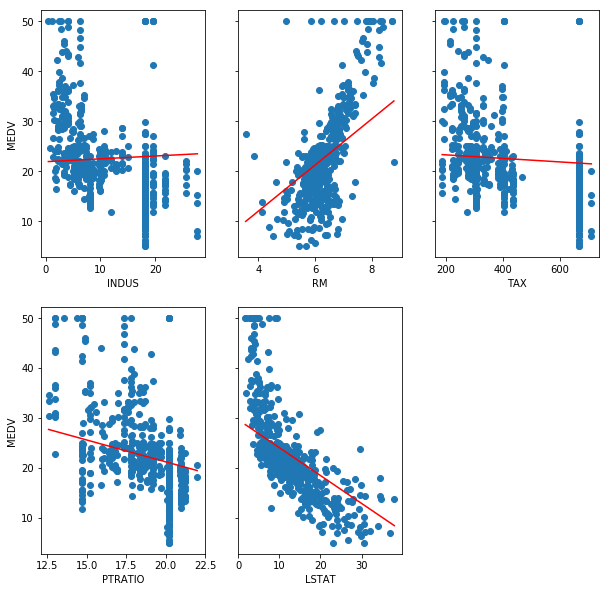

Ridge linear regression
explained_variance: 0.3559218987524056, 0.4834950073747163


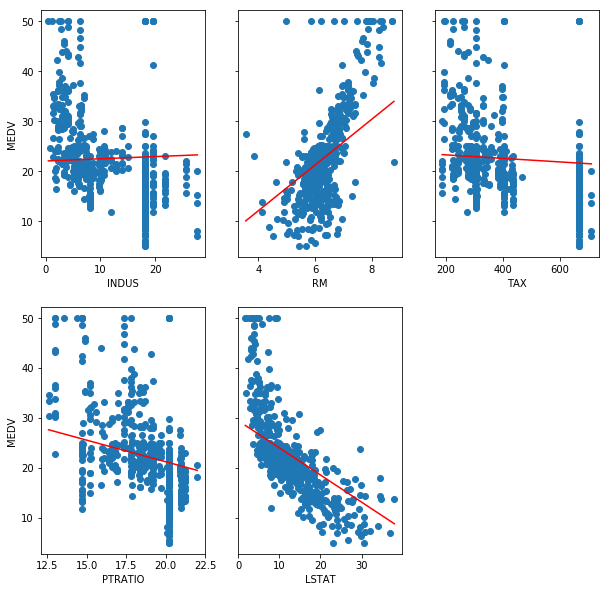

Support Vector regression
explained_variance: 0.4918590575054337, 0.28979496163544555


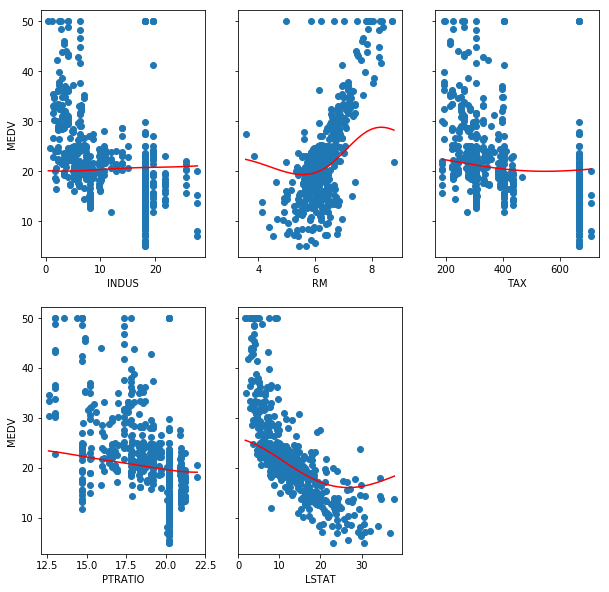

Random forest regression
explained_variance: 0.46113204396778196, 0.40211939895779364


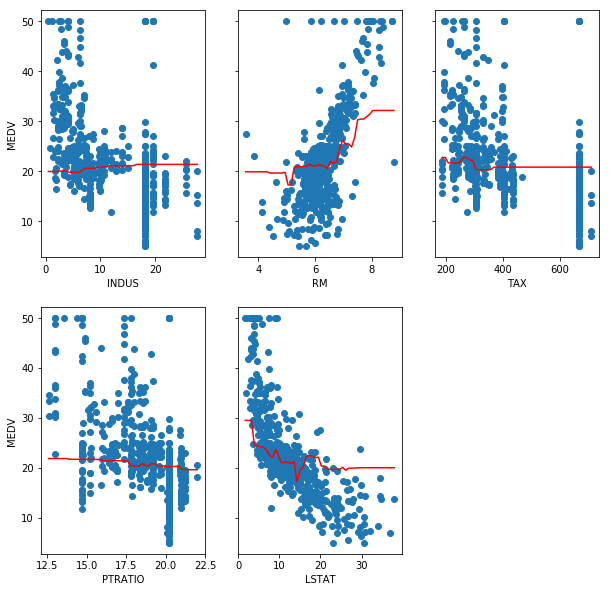

Polynomial regression
explained_variance: -994.805018822882, 2358.4282315465825


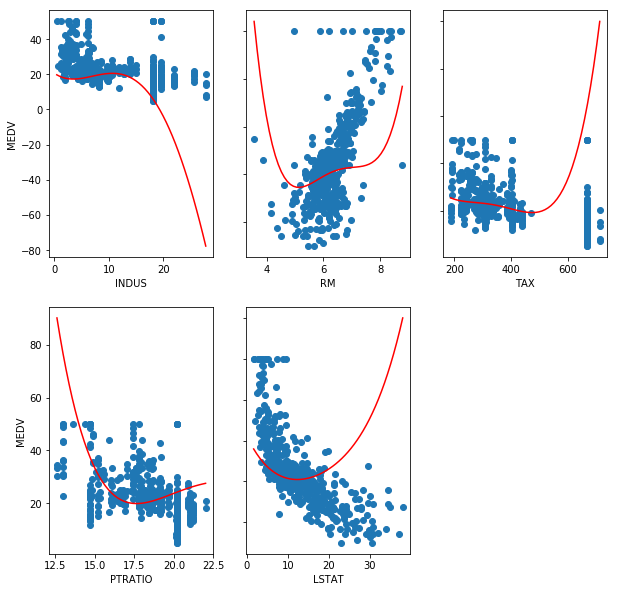

The best model is Support Vector regression with explained_variance = 0.4918590575054337


In [199]:
lr = lm.LinearRegression()
svr = svm.SVR()
ridge_reg = lm.RidgeCV(alphas=np.float_power(np.array([10] * 21), np.arange(-10, 11)))
random_forest_reg = ensemble.RandomForestRegressor()
poly_reg = pipeline.Pipeline([('poly', pp.PolynomialFeatures(degree=4)), ('linear', lm.LinearRegression())])
# svr_pipeline = pipeline.Pipeline([('scaler', pp.StandardScaler()), ('svr', svr)])
models = {'OLS linear regression' : lr, 'Ridge linear regression':ridge_reg, 'Support Vector regression':svr, 'Random forest regression' : random_forest_reg,
         'Polynomial regression':poly_reg}
# model = models[int(input())]
best_model = ''
best_metric = - np.inf
for name in models:
    print(name)
    res = use_model(models[name])
    if (best_metric < res):
        best_metric = res
        best_model = name
print('The best model is', best_model, 'with', scorer, '=', best_metric)

In [198]:
def use_model(model):
    model.fit(X_scaled, y)
    scores = model_selection.cross_val_score(model, X_scaled, y, cv=10, scoring=scorer)
    mean = scores.mean()
    print("{}: {}, {}".format(scorer, mean, scores.std()))
    visualize(model)
    return mean

### Визуализируем

In [187]:
def visualize(model):
    plt.rcParams["figure.figsize"] = (10,10)

    means = [X[:, i].mean() for i in range(X.shape[1])]
    rows, cols = (n_features + 2) / 3, 3
    for i in range(n_features):
        ax = plt.subplot(rows, cols, i + 1)
        plt.xlabel(selected_features[i])
        if (i % cols == 0):
            plt.ylabel(target_name)
        else:
            plt.setp(ax.get_yticklabels(), visible=False)
        cur_column = X[:, i]
        # actual data
        plt.scatter(cur_column, y)
        # prediction
        line_xs = np.linspace(cur_column.min(), cur_column.max())
        line_ys = []
        for x_ in line_xs:
            instance = [[0.] * n_features]
            instance[0][i] = x_
            for j in range(n_features):
                if j != i:
                    instance[0][j] = means[j]
            line_ys.append(model.predict(scaler.transform(instance)))
        plt.plot(line_xs, line_ys, color='red')

    plt.show()


In [ ]:
print(X[:5])
(df["Height"] - df["Height"].mean())[:5] / df["Height"].std(), (df["Age"] - df["Age"].mean())[:5] / df["Age"].std()
X.mean()["Height"], df["Height"].mean(), 1 / X.std()["Height"], 1 / df["Height"].std()